### Title: 
# Exploratory Data Analysis

### Description:
We are going to perform an EDA of our dataset.

### Authors:
#### Hugo Cesar Octavio del Sueldo
#### Jose Lopez Galdon

### Date:
23/10/2020

### Version:
1.0

***

### Libraries

We are going to start this EDA loading the respective libraries

In [276]:
    # Numpy & Pandas to work with the DF
import numpy as np
import pandas as pd

    # Seaborn / matplotlib for graphs
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
    
    # Random samples
from random import sample

    # Visualize DF
from IPython.display import display, HTML

    # Import Sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV

***

## Load data

In [277]:
    # To automate the work as much as possible, we will parameterize the codes, so in this case, we will create an objetct with
    # the path root
name = 'data_train_merge'

data = pd.read_csv(f'../data/02_intermediate/{name}.csv',  # Path root: here we include an f-string with the variable name to parametrize
                   low_memory = False)                     # To avoid warnings we use set low_memory = False

***

## Variable predict

Taking into account the goals of the practice, we only want to know those persons that `Fully paid` their loans or those who does not, so we will tansform de dependent variable into binary problem, to ones or ceros depending on that condition. 

In [278]:
    # We will only select those observations with "Fully Paid" & "Charged Off"
data_binary = data[(data['loan_status'] == "Fully Paid") | (data['loan_status'] == "Charged Off")]

    # Now, we will transform into 0 & 1
dummy_dict = {"Fully Paid":0, "Charged Off":1}

    # Finally, we use the dictiony in the dataset
data = data_binary.replace({"loan_status": dummy_dict})

### View data

Firstly, we are goint to take a look to our dataframe:

In [279]:
    # First 5 rows using html display in order to view all the columns
data = data
display(HTML(data.head().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
8,112038251,NaN,11575,11575,11575.0,36 months,7.35%,359.26,A,A4,Solutions Architect,6 years,OWN,153000.0,Not Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112038251,NaN,credit_card,Credit card refinancing,923xx,CA,16.99,0,Jul-1994,720,724,0,24.0,84.0,20,1,8550,22.7%,46,w,0.0,0.0,11707.816236,11707.82,11575.0,132.82,0.0,0.0,0.0,Sep-2017,11360.38,NaN,Sep-2017,724,720,0,24.0,1,Individual,NaN,NaN,NaN,0,0,442731,1.0,1.0,0.0,0.0,27.0,92315.0,63.0,2.0,8.0,1581.0,36.0,37600,1.0,6.0,2.0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,3.0,NaN,7.0,NaN,0,6,9,9,16,12,16,32.0,9,20,0.0,0,0,2,95.7,11.1,1,0,528172,100865,28100,120572,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
10,112149045,NaN,7200,7200,7200.0,36 months,24.85%,285.70,E,E3,Pse,2 years,RENT,50000.0,Source Verified,Jun-2017,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=112149045,NaN,debt_consolidation,Debt consolidation,985xx,WA,6.07,0,Jan-2000,685,689,0,72.0,NaN,4,0,3560,98.9%,5,w,0.0,0.0,7206.461000,7206.46,7200.0,6.46,0.0,0.0,0.0,Jul-2017,7231.31,NaN,Sep-2017,669,665,0,72.0,1,Individual,NaN,NaN,NaN,0,0,5588,0.0,1.0,0.0,1.0,21.0,2028.0,51.0,0.0,1.0,2779.0,74.0,3600,0.0,0.0,0.0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,14.0,NaN,14.0,NaN,1,2,2,3,3,1,3,3.0,2,4,0.0,0,0,0,80.0,100.0,0,0,7600,5588,3600,4000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
24,112052261,NaN,7500,7500,

In [280]:
    # Last 5 rows using html display in order to view all the columns
data = data
display(HTML(data.tail().to_html()))

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,last_credit_pull_d,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,application_type,annual_inc_joint,dti_joint,verification_status_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
884869,36221446,NaN,11575,11575,11575.0,36 months,15.59%,404.61,D,D1,Manager,10+ years,RENT,25400.0,Verified,Jan-2015,0,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36221446,NaN,credit_card,Credit card refinancing,791xx,TX,27.08,0,Jul-1999,680,684,0,NaN,NaN,9,0,18266,65%,18,f,0.0,0.0,13976.740000,13976.74,11575.00,2401.74,0.0,0.00,0.0000,Sep-2016,6281.14,NaN,Nov-2016,694,690,0,NaN,1,Individual,NaN,NaN,NaN,0,0,19798,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28100,NaN,NaN,NaN,1,2200.0,9234.0,66.4,0,0,113.0,184,48,8,0,48.0,NaN,14.0,NaN,0,7,7,7,10,5,8,13.0,7,9,0.0,0,0,1,100.0,42.9,0,0,29866,19798,27500,1766,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884870,36330911,NaN,12000,12000,12000.0,36 months,11.99%,398.52,B,B5,KYC Business Analyst,< 1 year,MORTGAGE,63000.0,Verified,Jan-2015,1,n,https://lendingclub.com/browse/loanDetail.action?loan_id=36330911,NaN,credit_card,Credit card refinancing,432xx,OH,23.69,1,Jun-1995,685,689,0,9.0,NaN,13,0,21110,69.7%,61,f,0.0,0.0,5164.770000,5164.77,3847.36,1317.41,0.0,0.00,0.0000,Feb-2016,398.52,NaN,Feb-2017,629,625,0,9.0,1,Individual,NaN,NaN,NaN,0,0,237002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,30300,NaN,NaN,NaN,11,18231.0,4776.0,69.0,0,0,121.0,233,1,1,1,1.0,NaN,14.0,NaN,1,4,8,4,5,40,8,20.0,8,13,0.0,0,1,3,98.3,50.0,0,0,325484,112990,15400,98125,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
884873,36271333,NaN,13

In [281]:
    # Data dimension
data.shape

(442567, 151)

### Data wrangling

After studying the whole dictionary, place in `references/dictionary.md`, we saw that there are some variables that we can not use them, because is information a posteriori, some examples of these columns are: `collection_recovery_fee`, `installment`, `last_credit_pull_d`, `last_pymnt_amnt`...

In [282]:
    # First, we make an objetc with the information of these columns
columns = ["collection_recovery_fee", "dti", "dti_joint", "fico_range_high", "fico_range_low", "grade", "initial_list_status", 
           "installment", "last_credit_pull_d", "last_fico_range_high", "last_fico_range_low", "last_pymnt_amnt", 
           "last_pymnt_d", "loan_amnt", "mths_since_last_delinq", "mths_since_last_major_derog", "mths_since_rcnt_il", 
           "next_pymnt_d", "mths_since_recent_bc", "mths_since_recent_bc_dlq", "mths_since_recent_inq", 
           "mths_since_recent_revol_delinq", "out_prncp", "out_prncp_inv", "pymnt_plan", "recoveries", "sub_grade", 
           "tot_coll_amt", "tot_cur_bal", "total_bal_ex_mort", "total_pymnt", "total_pymnt_inv", "total_rec_int", 
           "total_rec_late_fee", "total_rec_prncp", "total_rev_hi_lim", "verification_status", "verification_status_joint",
           "issue_d", "earliest_cr_line", "hardship_flag"]

    # Then we drop those columns
data = data.drop(columns = columns)

Once we have viewed our dataset, we continue exploring the column types and nulls...

In [283]:
data.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442567 entries, 8 to 884875
Data columns (total 110 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   id                                          442567 non-null  int64  
 1   member_id                                   0 non-null       float64
 2   funded_amnt                                 442567 non-null  int64  
 3   funded_amnt_inv                             442567 non-null  float64
 4   term                                        442567 non-null  object 
 5   int_rate                                    442567 non-null  object 
 6   emp_title                                   417552 non-null  object 
 7   emp_length                                  418693 non-null  object 
 8   home_ownership                              442567 non-null  object 
 9   annual_inc                                  442567 non-null  float64


As we can see above we have plenty of columns with nulls, so we are going to drop those columns which more than a 75% of the information is null.

In [284]:
    # For this operation we will use drop.na(), but firstly we will create an objet with the scale
thresh = round(len(data) * 0.75) 

data = data.dropna(thresh = thresh, axis = 1)

    #Lets check the data shape
data.shape

(442567, 60)

We can see that now we have only 64 columns, instead of 151. This is a huge reduction of the variables, but we continue having too much, in order to reduce them, we will study which of them are important in order to predict `loan_status`.

Other method we can use in order to select those variables which are important is, we could use a correlation matrix and select those whith hight correlation values, but with 65 columns will be too difficult... so we will use a smarter way:

*Select those variables with more than 80% of correlation between them and drop them*

In [285]:
    # To start, we create our objet called "correlated_features" and our correlation parameter
correlated_features = set()
corr_param = 0.8

    # Them, we drop our predict variable
correlation_matrix = data.drop('loan_status', axis=1).corr()

    # Finally we use a loop
for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > corr_param:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

correlated_features

{'funded_amnt_inv',
 'num_bc_sats',
 'num_op_rev_tl',
 'num_rev_accts',
 'num_rev_tl_bal_gt_0',
 'num_sats',
 'num_tl_30dpd',
 'percent_bc_gt_75',
 'tot_hi_cred_lim',
 'total_bc_limit'}

In [286]:
data = data.drop(correlated_features, axis = 1)

Now we will drop those columns which are not important to predict `loan_status`, using our business knowlege, some examples of them are `url`, `policy_code`, `title`, `purpose`...

In [287]:
    # First, we make an objetc with the information of these columns
columns = ["emp_title", "id", "policy_code", "purpose", "title", "url", "zip_code"]

    # Then we drop those columns
data = data.drop(columns = columns)

    # Check the dataset
data.shape

(442567, 43)

### Recursive Featuring Elimination

As we can see we have reduced the dataset a 33% but we still have to much columns, so, we are going to use RFE (Recursive Featuring Elimination) algorithm that *is basically a backward selection of the predictors. This technique begins by building a model on the entire set of predictors and computing an importance score for each predictor. The least important predictor(s) are then removed, the model is re-built, and importance scores are computed again. In practice, the analyst specifies the number of predictor subsets to evaluate as well as each subset’s size. Therefore, the subset size is a tuning parameter for RFE. The subset size that optimizes the performance criteria is used to select the predictors based on the importance rankings. The optimal subset is then used to train the final model.*

First of all, in order to run this algorithm we have to modify the columns types because it is a must to codify the categorical variables. Therefore, we will move forward analysing those columns that could changed for categorical and those that have symbols that could affect the code in a next step.

- `int_rate`, `revol_util`: Lets delete the "%" and convert the variable into a float object

- `emp_length`, `home_ownership`, `term`,**`loan_status`**, `addr_state`, `application_type`, `disbursement_method`, `debt_settlement_flag`: Codify 

In [288]:
    # With a apply and lamba function we, in the same line, convert the variable into a float and we drop the last 
    # element.
data['int_rate'] = data['int_rate'].apply(lambda x: float(x[:-1]))

In [289]:
    # Now, we convert the revol_util variable into an string object and the apply the same lamba function as above
data["revol_util"] = data["revol_util"].astype('category') 
data['revol_util'] = data['revol_util'].apply(lambda x: float(x[:-1])) 

In [291]:
    # We create and object we those variable that we want to convert into a categorical named columns_categ
columns_categ = ["emp_length", "home_ownership", "loan_status", "addr_state", "application_type", "term",
                 "disbursement_method", "debt_settlement_flag"]
    
    # Below, we transform the variables into categorical with the astype function.
data[columns_categ] = data[columns_categ].astype('category')

In [292]:
    #with a lambda and apply function we convert the different categories into the variable to a number 
data[columns_categ] = data[columns_categ].apply(lambda x: x.cat.codes)

Now, lets check the results of the functions created above

In [297]:
display(HTML(data.head().to_html()))

,funded_amnt,term,int_rate,emp_length,home_ownership,annual_inc,loan_status,addr_state,delinq_2yrs,inq_last_6mths,open_acc,pub_rec,revol_bal,revol_util,total_acc,collections_12_mths_ex_med,application_type,acc_now_delinq,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_tl,num_il_tl,num_tl_120dpd_2m,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,pub_rec_bankruptcies,tax_liens,total_il_high_credit_limit,disbursement_method,debt_settlement_flag
8,11575,0,7.35,6,2,153000.0,0,4,0,0,20,1,8550,22.7,46,0,0,0,8,23302.0,24269.0,13.6,0,0,130.0,275,3,3,2,0,6,9,16,12,0.0,0,2,95.7,1,0,120572,0,0
10,7200,0,24.85,2,3,50000.0,0,47,0,0,4,0,3560,98.9,5,0,0,0,2,1863.0,40.0,98.9,0,0,21.0,172,14,14,0,1,2,2,3,1,0.0,0,0,80.0,0,0,4000,0,0
24,7500,0,7.35,7,1,110000.0,0,43,0,2,19,0,23348,27.2,27,0,0,0,13,14551.0,60352.0,27.9,0,0,48.0,51,3,3,4,0,11,11,13,8,0.0,0,3,100.0,0,0,32239,0,0
42,10000,1,16.02,7,3,51979.0,0,4,0,0,15,2,5733,20.0,21,0,0,0,7,730.0,14628.0,22.2,0,0,130.0,54,6,6,0,0,3,7,8,4,0.0,0,3,100.0,2,0,5500,0,0
91,14000,0,16.02,7,1,75000.0,0,19,1,0,4,0,2700,90.0,10,0,0,0,5,31911.0,300.0,90.0,0,0,109.0,97,5,5,1,0,1,1,5,3,0.0,0,3,90.0,0,0,30321,0,0


To move forward with the RFE algorithm we need to drop the NaN's because it doesn't run with them, so let use the dropna function.

In [299]:
data = data.dropna() 
data.shape

(407290, 43)

As we can observe, we change from 442567 rows to 407290.

Due to the RFE algorithm it's so intensive in compute, and therefore expend to much time to drop the results we will work, at this stage, with a sample of 1000 random rows.

In [300]:
    #With the sample function, we create the sample with a seed and with replacement
minidata = data.sample(n = 1000, replace = True, random_state = 1322)

In [301]:
minidata.shape  #lets check the results

(1000, 43)

Finally, we can start with the RFE algorithm to select the variables

In [302]:
'''
X: it is the minidata df with the independent variables
target: it is the vector with the dependent variable
'''
X = minidata.drop('loan_status', axis=1)
target = minidata['loan_status']

In [303]:
'''
rfc: it is the object that contains the RandomForestClassifier that we will use in the RFECV.
'''
rfc = RandomForestClassifier(random_state=1322)

In [304]:
'''
rfecv: it is an RFE with Cross Validation. 
    Parameters:
        Estimator = the object rfc created above that contains the information about the feature importance
        step = number of features to remove at each iteration
        cv = currently, we are using a StratifiedKFold cross validation with k equals to 10
        scoring = the metric chosen.
'''
rfecv = RFECV(estimator = rfc, step = 1, cv = StratifiedKFold(10), scoring = 'accuracy')

'''
rfecv.fit: this function fitted the predictive variable according to our model
'''
rfecv.fit(X, target)

RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=RandomForestClassifier(random_state=1322), scoring='accuracy')

Once the execution finishes, you can use this line of code to see how many features are optimal to produce the best accuracy (or whatever your chosen metric is):

In [305]:
print('Optimal number of features: {}'.format(rfecv.n_features_))

Optimal number of features: 30


Not only this, but you can also plot the accuracy obtained with every number of features used:

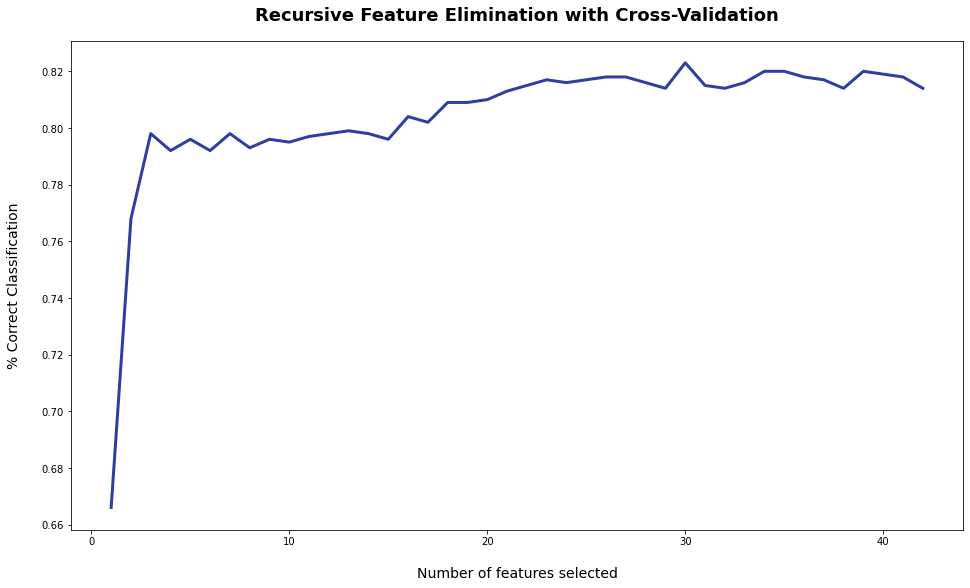

In [306]:
plt.figure(figsize=(16, 9))
plt.title('Recursive Feature Elimination with Cross-Validation', fontsize=18, fontweight='bold', pad=20)
plt.xlabel('Number of features selected', fontsize=14, labelpad=20)
plt.ylabel('% Correct Classification', fontsize=14, labelpad=20)
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, color='#303F9F', linewidth=3)

plt.show()

It is visible that with 30 features the accuracy was more than 80%, which is very good taking account that we initially have 150 variables. 

You can also print out which features are considered to be least important and drop them with this snippet:

In [307]:
print(np.where(rfecv.support_ == False)[0])

X.drop(X.columns[np.where(rfecv.support_ == False)[0]], axis=1, inplace=True)

[ 7 10 14 15 16 21 22 33 34 37 38 40]


The instance of RFECV has also a nifty feature_importances attribute which is worthy to be checked out

In [308]:
rfecv.estimator_.feature_importances_

array([0.04460678, 0.03884873, 0.07336941, 0.02758814, 0.0158777 ,
       0.0421063 , 0.03588364, 0.0159047 , 0.02772948, 0.03534728,
       0.04515875, 0.03394621, 0.02203621, 0.05025484, 0.03906354,
       0.03954572, 0.04670001, 0.04496389, 0.0284137 , 0.02572513,
       0.01855125, 0.01157488, 0.02387968, 0.0251446 , 0.02677714,
       0.03085123, 0.02164652, 0.02562304, 0.04941114, 0.03347039])

Okay, okay, don’t scream at me just yet. I know that this doesn’t tell you much. Thankfully, this is pretty easy to visualize. One way is to create a DataFrame object with attributes as one column and the importance as the other, and then just simply sort the DataFrame by importance in descending order. Then you can use the power of plotting libraries such as Matplotlib to draw a Bar chart (horizontal is preferred for this scenario) to get a nice visual representation. Here’s the code for doing so:

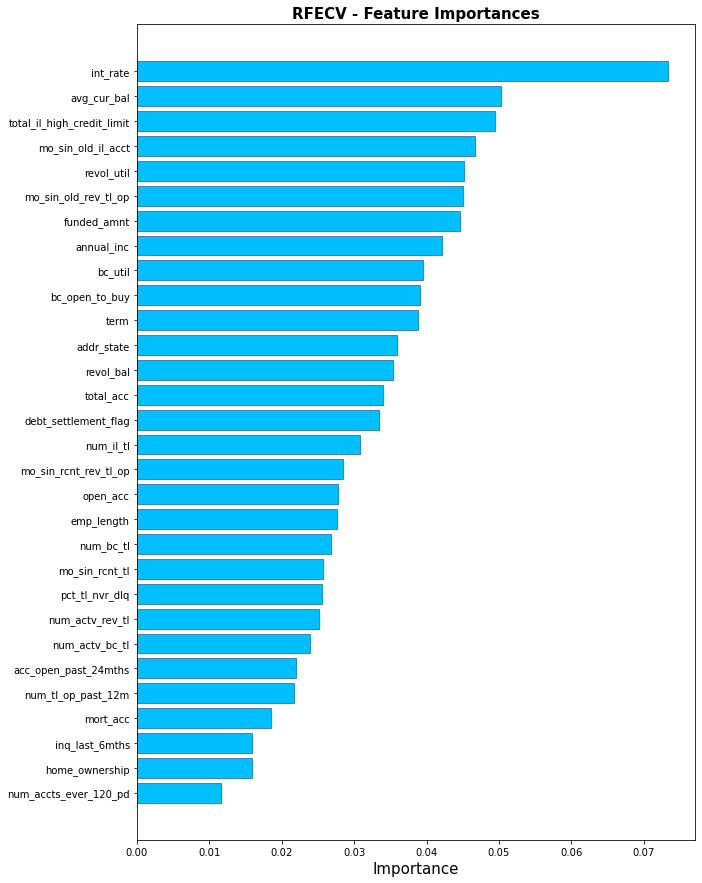

In [318]:
'''
Firstly, we create an emplty df.
Second, we create two columns. One for the variables names and another with the % importance of each.

Finnaly, we sort them in ascending order.


'''
df_viz = pd.DataFrame()
df_viz['attr'] = X.columns
df_viz['importance'] = rfecv.estimator_.feature_importances_

df_viz = df_viz.sort_values(by='importance', ascending=True)

    # Bar Plot
plt.figure(figsize = (10, 15))
plt.barh(y = df_viz['attr'], width = df_viz['importance'], color = 'deepskyblue', edgecolor = "steelblue")
plt.title('RFECV - Feature Importances', fontsize = 15, fontweight = 'bold')
plt.xlabel('Importance', fontsize = 15)
plt.show()

At this stage, the most important variable is the int_rate(interest rate), this make sense because when we have a client with high interest rate, this is due to a high risk. The interest rate depends of the total amount of the loan, the term, the emp_title, emp_length... so on.

The number of mortage accounts (mort_acc) it isn't signicate explaining the loaning state. That is a little weird because a person with multiple mortage account could be a risky customer and probably a default borrower.